# Chapter 5 - Resampling Methods

In [1]:
import io
import requests
import warnings
warnings.filterwarnings('ignore')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, LeaveOneOut, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils import resample
%matplotlib inline

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main'

## 1. Cross Validation

**목표:**
- Validation set approach, LOOCV, k-fold CV의 장단점 파악하기
- Cross-validation의 유용성 파악하기
- 데이터셋을 training set, validation set으로 분리하는 방법 배우기

- 3장 61p:
  - mpg와 horsepower간의 비선형적인 관계
  - 2차 모델을 썼을 때 가장 좋고, 오히려 5차 모델을 쓰면 너무 overfitting됨.
  - 다른 차원의 모델은 어떨까? 2차원이 여전히 가장 좋을까?
  
     => validation set approach를 사용해서 확인!


### 1.1. Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
df = pd.read_csv(f'{BASE_DIR}/Data/Auto.csv', na_values='?').dropna() # drop missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


### 1.2. Validation Set Approach (Figure 5.2)
We will use polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features


- Validation set approach: 이론에서 배우셨을텐데, 데이터셋을 반으로 나눔 (392 ⇒ 196 * 2). 반은 학습을 위해 쓰고, 반은 MSE를 계산함. 여러 차원의 모델에 대해서 이것을 진행했을 때 왼쪽 그림을 얻음.

- 단점:
  - training set / validation set에 어떤 데이터가 갔는지에 따라 test error rate의 변동성이 굉장히 큼.
  - 데이터셋의 일부분만 쓰이게 되어서 데이터셋이 작을 경우에는 안 좋음. 특히 작은 데이터셋으로 학습된 모델은 큰 데이터셋으로 학습된 경우보다 성능이 더 안 좋음. 따라서 에러가 더 크게 보여지는 경우가 있음.
- 장점: 간단하고 쉬움.

* 다항회귀란 위와 같이 데이터들간의 형태가 비선형 일때 데이터에 각 특성의 제곱을 추가해주어서 특성이 추가된 비선형 데이터를 선형 회귀 모델로 훈련시키는 방법이다.

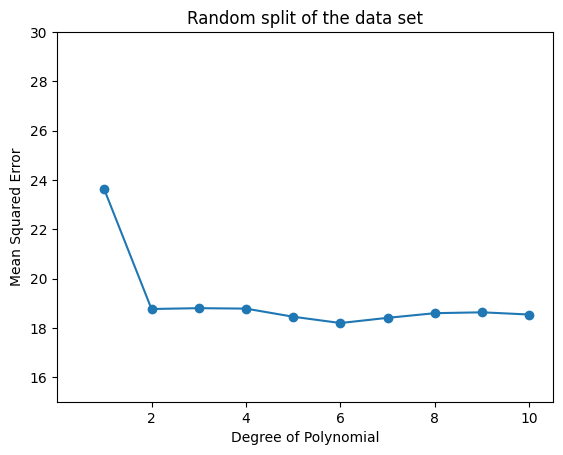

In [3]:
test_size = 0.5
degrees = range(1, 11)
MSE = np.zeros((10))

for degree in degrees:
  poly = PolynomialFeatures(degree) # => input data의 양이 달라짐 (점점 많아짐)
  X = poly.fit_transform(df.horsepower.values.reshape(-1,1)) # -1: inferred
  y = df.mpg # Flatten data
  # random_state: shuffle data before splitting. same number = same shuffling
  # data 나누는 방식에 대한 영향을 안 받기 위해서
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

  regr = skl_lm.LinearRegression()
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)
  MSE[degree-1]= mean_squared_error(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(degrees, MSE, '-o')
ax.set_title('Random split of the data set')
ax.set_ylabel('Mean Squared Error')
ax.set_ylim(15, 30)
ax.set_xlabel('Degree of Polynomial')
ax.set_xlim(0, 10.5)
ax.set_xticks(range(2, 11, 2))

- 보면 2차원은 확실히 선형 회의 모델보다는 훨씬 더 좋음. 그런데 차원이 높아진다고 더 좋아지는 것은 아님. 오히려 cubic 혹은 4차원의 경우 조금 더 높은 것을 볼 수 있음.


---


- 데이터셋을 나눌 때 나누는 방식에 따라 MSE 결과가 달라질 수 있음. 그래서 오른쪽 그래프는 나누는 방식을 10번 다 다르게 해서 MSE를 여러 차원에 대해 구한 것임.

- 이걸 구현하려면 어떻게? 각 차원마다 서로 다른 데이터셋 분할 방법으로 만들어진 데이터셋을 사용해서 regression 모델 학습 후 MSE 계산.

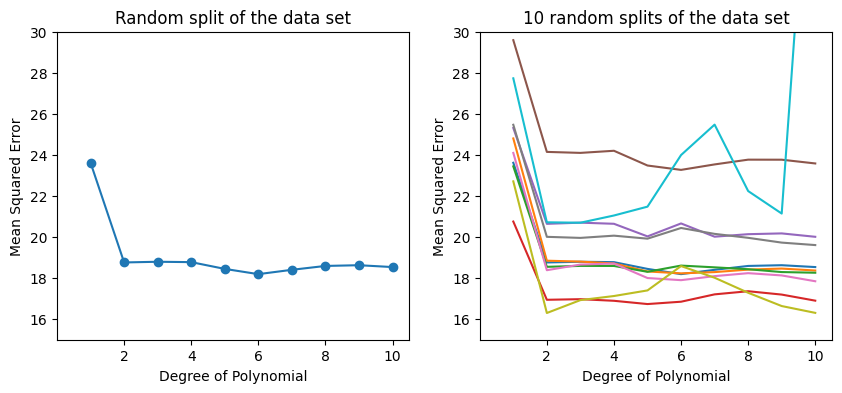

In [4]:
test_size = 0.5
degrees = range(1, 11)
MSEs = np.zeros((10, 10))

# Generate 10 random splits of the dataset (10개 polynomial degree * 10 random splits = 100 iterations)
for degree in degrees:
    for random_state in range(10):
        poly = PolynomialFeatures(degree) # => input data의 양이 달라짐 (점점 많아짐)
        X = poly.fit_transform(df.horsepower.values.reshape(-1,1)) # -1: inferred
        y = df.mpg.ravel() # Flatten data
        # random_state: shuffle data before splitting. same number = same shuffling
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        regr = skl_lm.LinearRegression()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        MSEs[degree-1,random_state]= mean_squared_error(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(degrees, MSEs[:, 0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(degrees, MSEs)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15, 30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0, 10.5)
    ax.set_xticks(range(2, 11, 2))

- 데이터를 어떻게 반으로 나눴는지에 따라서 학습되는 모델이 달라지고, 결국 MSE도 서로 많이 달라지게 됨 (거의 16 차이가 남)
- 10개 다 1차원 보다는 2차원이 더 작은 MSE를 갖음.
- 2차원보다 더 큰 차원을 봐도 큰 이점이 없음.

### 1.3. Compare LOOCV, 10-fold, 5-fold cross validation (Figure 5.4)

- 여태까지 한 것: Validation set approach를 통해서 데이터셋을 분리해, 모델 차원에 따라 MSE가 어떯게 변하는지를 파악했음. Validation set approach는 사실 2-fold cross validation이라고 볼 수 있음.
- 이제는 같은 작업을 1-fold cross-validation (LOOCV), 5-fold cross-validation, 10-fold cross validation을 적용해서 어떤 cross-validation이 데이터셋의 분리방법에 따라 큰 변동성이 없는지 확인.

In [5]:
degrees = range(1,11)

In [6]:
# LeaveOneOut Cross Validation: 하나의 데이터를 validation set으로 두고 나머지에 대해서 학습. 이걸 모든 데이터에 대해서 반복함.
# 수행 시간이 느림 => 데이터셋 크기만큼 학습을 해야해서 (392번)
# 핵심: cross_val_score, LeaveOneOut

regr = skl_lm.LinearRegression()
loo = LeaveOneOut()

score_raw_loo = np.zeros([10, df.shape[0]])
score_mean_loo = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    y = df.mpg.ravel()

    scores = cross_val_score(regr, X, y, cv=loo, scoring='neg_mean_squared_error') # scoring을 neg_mean_squared_error로 해줌 (negated MSE)


    score_raw_loo[degree-1,:] = scores
    score_mean_loo.append(np.mean(scores))

In [7]:
# 10-fold Cross Validation: 데이터셋을 10개의 파트로 나눠 각 파트를 validation set, 나머지를 training set으로 학습.
# 수행 시간이 빠름 => 10개의 파트로 나눴으니 10번만 학습하면 됨

folds = 10

kf_10 = KFold(n_splits=folds)

score_raw_10fold = np.zeros([10, folds])
score_mean_10fold = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    y = df.mpg.ravel()

    scores = cross_val_score(regr, X, y, cv=kf_10, scoring='neg_mean_squared_error')  # predefined functions

    score_raw_10fold[degree-1,:] = scores
    score_mean_10fold.append(np.mean(scores))

In [8]:
# 5-fold Cross Validation: 데이터셋을 5개의 파트로 나눠 각 파트를 validation set, 나머지를 training set으로 학습.
# 5번만 학습해도 되어서 가장 빠름

folds = 5

score_raw_5fold = np.zeros([10, folds])
score_mean_5fold = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    y = df.mpg.ravel()

    scores = cross_val_score(regr, X, y, cv=folds, scoring='neg_mean_squared_error')

    score_raw_5fold[degree-1,:] = scores
    score_mean_5fold.append(np.mean(scores))

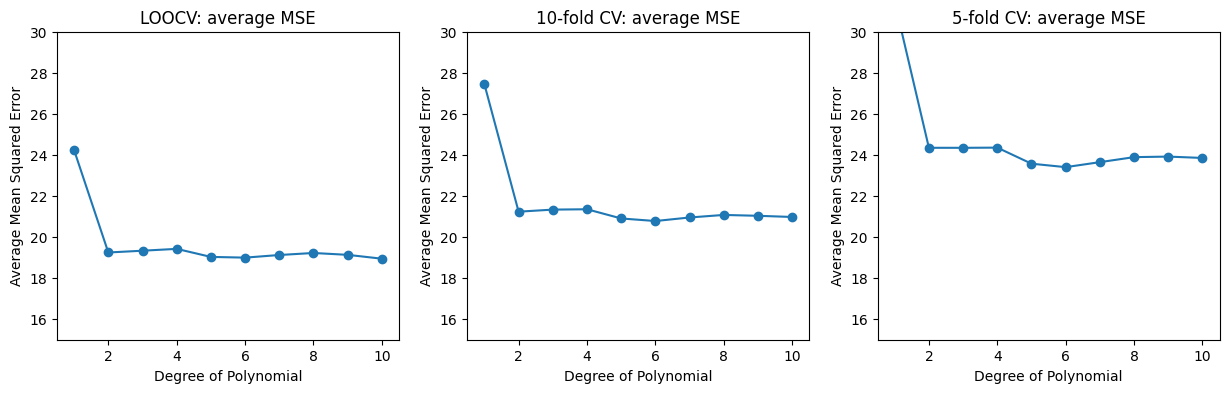

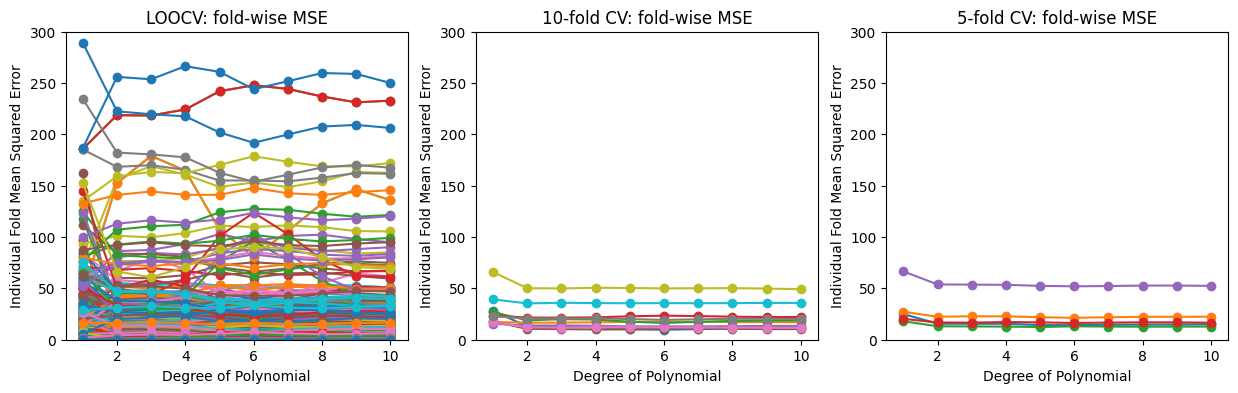

In [9]:
## Upper plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Left plot
ax1.set_title('LOOCV: average MSE')
ax1.plot(degrees, np.array(score_mean_loo)*-1, '-o') # Why -1?? Because negated MSE

# Middle plot
ax2.set_title('10-fold CV: average MSE')
ax2.plot(degrees, np.array(score_mean_10fold)*-1,'-o')

# Right plot
ax3.set_title('5-fold CV: average MSE')
ax3.plot(degrees, np.array(score_mean_5fold)*-1,'-o')

for ax in fig.axes:
    ax.set_ylabel('Average Mean Squared Error')
    ax.set_ylim(15, 30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
plt.show()


## Lower plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Left plot
for i in range(df.shape[0]):
    ax1.set_title('LOOCV: fold-wise MSE')
    ax1.plot(degrees, score_raw_loo[:,i]*-1,'-o')

# Middle plot
for i in range(10):
    ax2.set_title('10-fold CV: fold-wise MSE')
    ax2.plot(degrees, score_raw_10fold[:,i]*-1,'-o')

# Right plot
for i in range(5):
    ax3.set_title('5-fold CV: fold-wise MSE')
    ax3.plot(degrees, score_raw_5fold[:,i]*-1,'-o')

for ax in fig.axes:
    ax.set_ylabel('Individual Fold Mean Squared Error')
    ax.set_ylim(0, 300)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
plt.show()

* plot의 개수 많음 => computationally heavy
* 변동석이 큼 => 데이터가 비슷
* 장점은 training 데이터셋이 커서 bias가 적음

* 변동성이 적음 => 데이터가 달라서
* 장점: computationally efficient

* 3다: 1차원보다 2차원이 낫고, 그 이상의 차원에 큰 이득이 없음.

* LOOCV:
  * 장점:
    * 학습 데이터셋의 크기가 커서 (원래 데이터셋보다 하나 작음) bias가 적고 test error rate를 더 크게 나타내주지 않음.
    * plot이 많이 겹침 ==> split된 각각의 데이터셋이 서로랑 굉장히 비슷함 (하나의 데이터로만 차이가 남). 따라서 많이 겹침.
  * 단점:
    * plot의 개수 많음 (392개) ==> computationally expensive
    * plot의 값의 폭이 큼 (300까지) ==> 데이터셋이 서로 굉장히 비슷해서 outlier 데이터에 굉장히 민감하게 반응하고 MSE의 평균을 내도 outlier 데이터의 영향을 많이 받음 => 변동성이 높음

* 10-fold / 5-fold:
  * plot의 개수 (각각 10개, 5개) ==> computationally better
  * 변동성이 적음 => fold가 서로 많이 달라서 noise에 민감하지 않음 (noise가 분산이 됨)
  * 2나 10이나 거의 비슷함 => 굳이 데이터 다 많이 만드는 10을 안 써도 됨

### 1.4. Exercise

This time, we will repeat the above process using the (weight, mpg) as the dataset.

1. Load f'{BASE_DIR}/Data/Auto.csv', and plot the scatter plot of the ('weight', 'mpg') from the loaded dataset.
2. Compare LOOCV, 10-fold, 5-fold cross validation by plotting the average MSE and the fold-wise MSE.

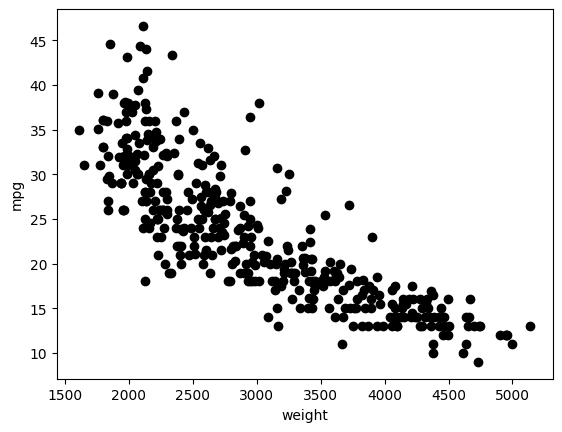

In [ ]:
# Load f'{BASE_DIR}/Data/Auto.csv'
df = pd.read_csv(f'{BASE_DIR}/Data/Auto.csv', na_values='?').dropna()

# Plot the scatter plot of the ('weight', 'mpg') from the loaded dataset.
X = df.weight.values
y = df.mpg.values

plt.scatter(X, y,  color='black')
plt.xlabel("weight")
plt.ylabel("mpg")
plt.show()

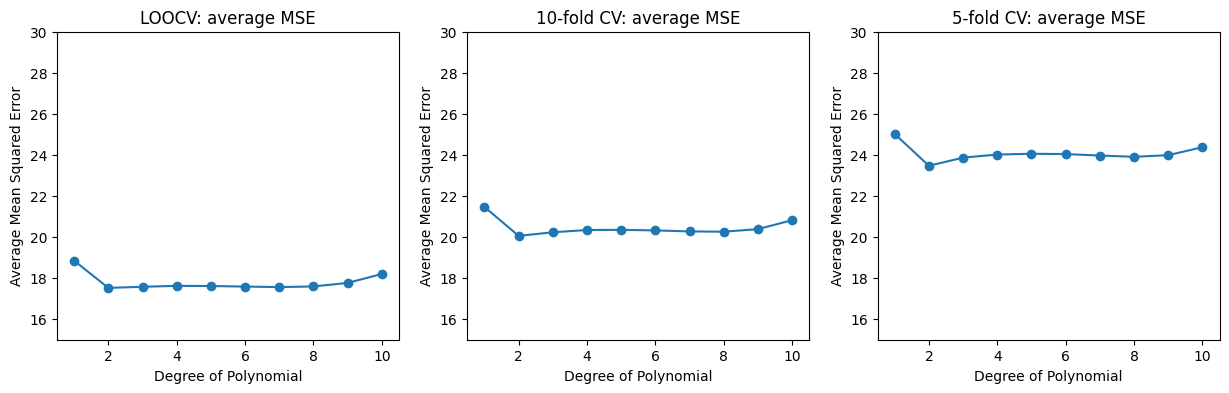

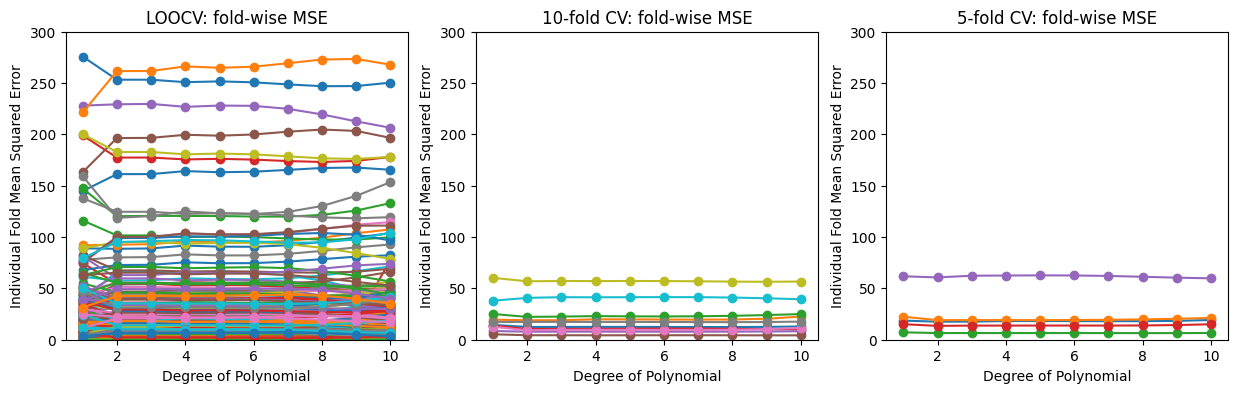

In [ ]:
# Compare LOOCV, 10-fold, 5-fold cross validation by plotting the average MSE and the fold-wise MSE

degrees = range(1,11)

# LeaveOneOut Cross Validation
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()

score_raw_loo = np.zeros([10, df.shape[0]])
score_mean_loo = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.weight.values.reshape(-1,1))
    y = df.mpg.ravel()

    scores = cross_val_score(regr, X, y, cv=loo, scoring='neg_mean_squared_error')

    score_raw_loo[degree-1,:] = scores
    score_mean_loo.append(np.mean(scores))

# 10-fold Cross Validation
folds = 10

kf_10 = KFold(n_splits=folds)

score_raw_10fold = np.zeros([10, folds])
score_mean_10fold = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.weight.values.reshape(-1,1))
    y = df.mpg.ravel()

    scores = cross_val_score(regr, X, y, cv=kf_10, scoring='neg_mean_squared_error')

    score_raw_10fold[degree-1,:] = scores
    score_mean_10fold.append(np.mean(scores))

# 5-fold Cross Validation
folds = 5

score_raw_5fold = np.zeros([10, folds])
score_mean_5fold = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(df.weight.values.reshape(-1,1))
    y = df.mpg.ravel()

    scores = cross_val_score(regr, X, y, cv=folds, scoring='neg_mean_squared_error')

    score_raw_5fold[degree-1,:] = scores
    score_mean_5fold.append(np.mean(scores))


## Upper plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Left plot
ax1.set_title('LOOCV: average MSE')
ax1.plot(degrees, np.array(score_mean_loo)*-1, '-o')

# Middle plot
ax2.set_title('10-fold CV: average MSE')
ax2.plot(degrees, np.array(score_mean_10fold)*-1,'-o')

# Right plot
ax3.set_title('5-fold CV: average MSE')
ax3.plot(degrees, np.array(score_mean_5fold)*-1,'-o')

for ax in fig.axes:
    ax.set_ylabel('Average Mean Squared Error')
    ax.set_ylim(15, 30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
plt.show()

## Lower plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Left plot
for i in range(df.shape[0]):
    ax1.set_title('LOOCV: fold-wise MSE')
    ax1.plot(degrees, score_raw_loo[:,i]*-1,'-o')

# Middle plot
for i in range(10):
    ax2.set_title('10-fold CV: fold-wise MSE')
    ax2.plot(degrees, score_raw_10fold[:,i]*-1,'-o')

# Right plot
for i in range(5):
    ax3.set_title('5-fold CV: fold-wise MSE')
    ax3.plot(degrees, score_raw_5fold[:,i]*-1,'-o')

for ax in fig.axes:
    ax.set_ylabel('Individual Fold Mean Squared Error')
    ax.set_ylim(0, 300)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
plt.show()

Cross validation을 쓰는 이유:
1. 저희가 본 것처럼, 하나의 estimator에 대한 parameter tuning, 혹은 여러 종류의 estimator 간의 성능 비교를 위해 가장 낮은 에러를 갖는 모델을 찾기 위해. ==> minimum point of MSE is important, but the actual value of MSE is not
2. 우리가 사용하고 있는 모델이 실제 test data에 얼마나 잘 할지, 성능 예측을 하기 위해서, 즉 test error estimation을 하기 위해서. ==> 실제 MSE 값이 중요

## 2. Bootstrap

**목표:**
* resample, multivariate_normal 함수 쓰기
* bootstrap 유용성 확인하기

p36, p37

Want to estimate alpha ==> must estimate etc. based on previous datasets of X and Y

모집단에서 총 4번, 100개의 sample을 갖는 데이터셋을 simulate하기 위해 샘플링을 하고, simulated dataset을 이용해 alpha 값을 추정한다.

모집단은 [0, 0], [[1, 0.5], [0.5, 1.25]]를 따르는 다변량 정규분포라고 가정한다. mean, covariance를 직접 넣어줘야 실제 alpha 값을 알 수 있어 (0.6) 추정된 alpha 값들의 정확도를 알아낼 수 있음.

### 2.1. Simulate 4 different datasets and estimate  $\alpha$

In [12]:

_mean = [0, 0]
_cov = [[1, 0],
        [0, 1]]
multi_norm2 = np.random.multivariate_normal(_mean, _cov, size=5)  # multivariate normal distribution: 다변량 정규 분포. Univariable gaussian distrubtion에서와 마찬가지로 mean과 covariance가 필요함
print(multi_norm2.shape) # 2차원 mean, cov를 줬기 때문에 반환되는 정규분포도 2차원
_x = multi_norm2[:, 0]
# _mean = [0, 0, 0]
# _cov = [[1, 0, 0],
#         [0, 1, 0],
#         [0, 0, 1]]
# multi_norm3 = np.random.multivariate_normal(_mean, _cov, size=5)
# print(multi_norm3.shape) # 3차원 mean, cov를 줬기 때문에 반환되는 정규분포도 3차원

# Transpose하면 (2, N), 즉 X, Y 좌표가 첫번째 dimension에 있음
print(multi_norm2.T.shape)
_X, _Y = multi_norm2.T
print(_X.shape)
print(_X)
print(_Y.shape)
print(_Y)

(5, 2)
(2, 5)
(5,)
[ 0.8408315  -2.23772025  0.09498696  1.25305081  1.88876466]
(5,)
[ 0.08498257  0.07366034  1.7615985  -1.24547836  2.66894988]


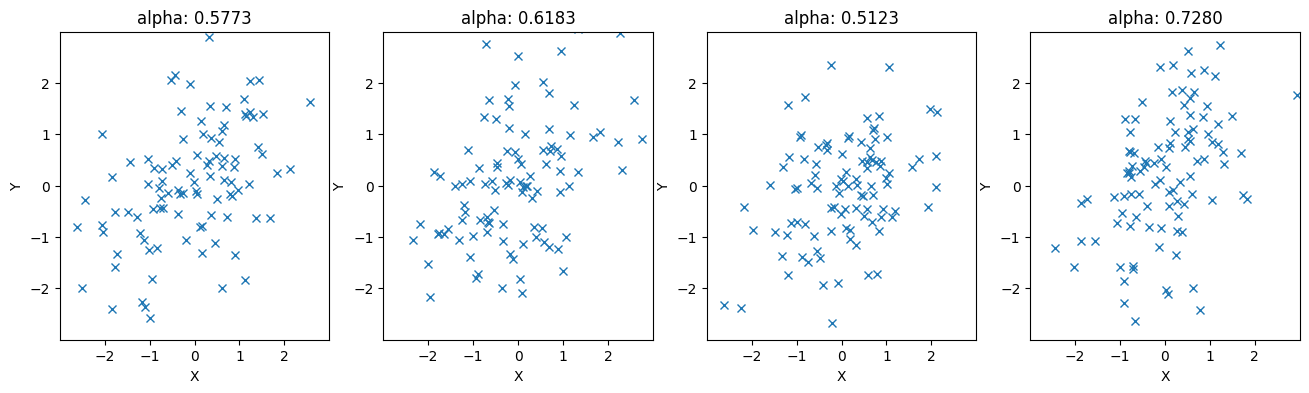

In [ ]:
mean = [0, 0]
cov = [[1,   0.5],
       [0.5, 1.25]]  # 실제 alpha 값을 알 수 있게 이렇게 줌. 우리는 이 변수로 정규 분포에서 random X, Y 데이터셋을 만들어서 alpha 추정치를 계산할 예정
# => alpha = 0.6

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))
n_samples = 100

def calc_alpha(x, y):
    '''
    Lecture5-2 Cross Validation, slide 36/66
    '''
    var_x = np.var(x)
    var_y = np.var(y)
    cov_xy = np.cov(x,y)[0,1]
    a_hat = (var_y - cov_xy)/(var_x + var_y - 2*cov_xy)
    return a_hat

# 1st plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T  # original population에서 무한대로 sampling할 수 있다는 가정
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax1.set_title(title)
ax1.plot(x, y, 'x')

# 2nd plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax2.set_title(title)
ax2.plot(x, y, 'x')

# 3rd plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax3.set_title(title)
ax3.plot(x, y, 'x')

# 4th plot
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
title = 'alpha: {:.4f}'.format(calc_alpha(x, y))
ax4.set_title(title)
ax4.plot(x, y, 'x')

for ax in fig.axes:
    ax.set_ylabel('Y')
    ax.set_ylim(-3, 3)
    ax.set_xlabel('X')
    ax.set_xlim(-3, 3)
    ax.set_xticks(range(-2, 3, 1));
    ax.set_yticks(range(-2, 3, 1));

X, Y 쌍을 100개 simulate 해서 alpha 값을 추정함.


---

그렇다면 우리가 추정한 alpha값은 얼마나 실제 alpha 값과 근사할까? alpha_hat의 표준편차를 알아내기 위해서는 위 절차를 1000번 반복해서 구한 alpha값들을 histogram으로 그려본다.

### 2.2. Repeat the above process 1000 time and plot histograms of $\alpha$

Estimated alpha from 1000 simulated datasets: 0.5977 +- 0.0818


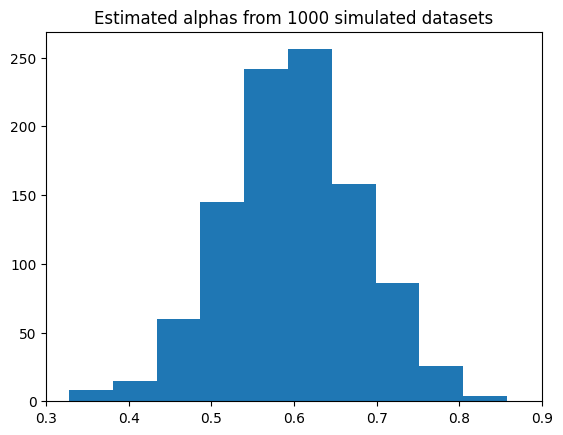

In [ ]:
a_hat_list = []
for i in range(1000):
    x, y = np.random.multivariate_normal(mean, cov, n_samples).T
    a_hat_list.append(calc_alpha(x, y))

print('Estimated alpha from 1000 simulated datasets: {:.4f} +- {:.4f}'.format(np.mean(a_hat_list), np.std(a_hat_list)))

plt.figure()
plt.title('Estimated alphas from 1000 simulated datasets')
plt.hist(a_hat_list)
plt.xlim(0.3, 0.9)
plt.show()

* 표준편차는 약 0.08정도 나옴. 즉, alpha는 alpha_hat과 평균적으로 0.08 정도 차이남.

---

* 문제는 실전에서는 우리가 했던 것처럼 매번 original population에서 샘플링을 할 수 없음.

==> bootstrap! 추가로 데이터를 생성하지 않은채 같은 데이터셋으로 여러 데이터셋이 있는 효과 내서 alpha 값을 추정할 것임.

### 2.3. Generate 1000 bootstrap datasets and estimate $\alpha$

하나의 큰 dataset에서 복원추출을 해서 작은 데이터셋을 여러개 만들고 (bootstrap), 각각에 대해서 alpha를 구해서 실제 alpha 값 근사해볼 것임. Bootstraping을 위해 사용하는 함수는 sklearn.utils.resample().

To create bootstrap datasets, we can use sklearn.utils.resample() function
e.g., x_hat, y_hat = resample(x, y, n_samples=n_samples)

Estimated alpha from 1000 bootstrap datasets from a single simulation dataset: 0.5907 +- 0.0706


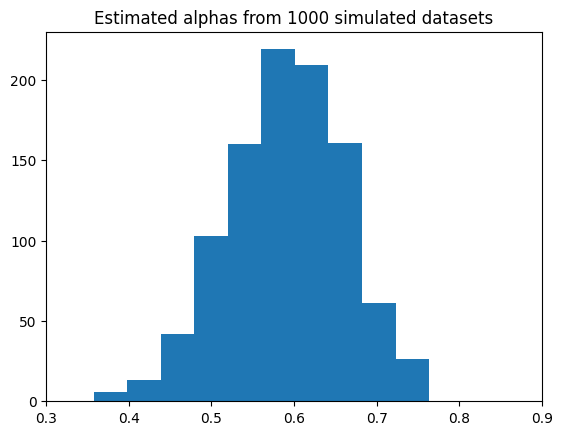

In [ ]:
# sample one (x,y) dataset
x, y = np.random.multivariate_normal(mean, cov, n_samples).T

# generate 1000 bootstrap samples, estimate alpha, and save
a_hat_list = []
for i in range(1000):
    x_hat, y_hat = resample(x, y, n_samples=n_samples)
    a_hat_list.append(calc_alpha(x_hat, y_hat))

print('Estimated alpha from 1000 bootstrap datasets from a single simulation dataset: {:.4f} +- {:.4f}'.format(np.mean(a_hat_list), np.std(a_hat_list)))

# plot the histrogram of the estimated alphas
plt.figure()
plt.title('Estimated alphas from 1000 distinct bootstap datasets')
plt.hist(a_hat_list)
plt.xlim(0.3, 0.9)
plt.show()

조금 이전에 그린 1000개의 simulated dataset histogram과 매우 유사함.
최종 alpha값을 보면 실제 alpha값과 비슷하고, 표준편차도 매우 비슷함.

즉, 같은 데이터셋에서 뽑은 건데도 불구하고, 1000개의 dataset을 가지는 것과 같은 성능을 냄. ==> bootstrap 쵝오!

## 3. Automation

Parameter tuning을 시켜줄 수 있는 두 가지 기능 소개 예정:
- 하나는 Pipeline
- 다른 하나는 GridSearch

**목표:**
* Pipeline 쓰는 법 배우기
* GridSearchCV 쓰는 법 배우기
* Pipeline의 유용성 이해하기

### 3.1. Pipeline

* Pipeline: 데이터 전처리, 모델 학습까지 하나로 묶어주는 것. 즉, pipeline = transforms + estimator.
  * 같이 묶을 수 있는 operation은 transform이어야함, 즉 fit과 transform 함수를 구현하는 객체여야함. estimator의 경우 fit 함수만 구현하는 거면 됨.
* Pipeline 이점 1: 데이터 학습에 필요한 여러 step을 하나로 묶을 수 있고, 각각의 step에 해당되는 parameter를 자유롭게 설정할 수 있다

In [13]:
standard_knn = Pipeline([
    ('scaler', StandardScaler()), # Transform (normalize 해줌)
    ('knn', KNeighborsClassifier(n_neighbors=2)), # Estimator
], memory='.', verbose=True)      # memory: transformers 결과 cache 경로, verbose: estimator fitting할 때 step이 프린트가 됨

In [14]:
standard_knn.get_params() # transform, estimator의 params 돌려줌

{'memory': '.',
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=2))],
 'verbose': True,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=2),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 2,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [17]:
standard_knn.set_params(knn__n_neighbors=1, scaler__with_mean=False)
standard_knn.get_params()

{'memory': '.',
 'steps': [('scaler', StandardScaler(with_mean=False)),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': True,
 'scaler': StandardScaler(with_mean=False),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': False,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [18]:
# 예시로 첫 수업에서 사용했던 iris dataset에 대해 저희 standard_knn을 학습/평가 해보기

iris = load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [19]:
standard_knn.fit(X_train, y_train) # verbose=True로 했기때문에 로그가 찍힘. 안 하면 안 찍힘.

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


Pipeline(memory='.',
         steps=[('scaler', StandardScaler(with_mean=False)),
                ('knn', KNeighborsClassifier(n_neighbors=1))],
         verbose=True)

In [20]:
y_pred = standard_knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



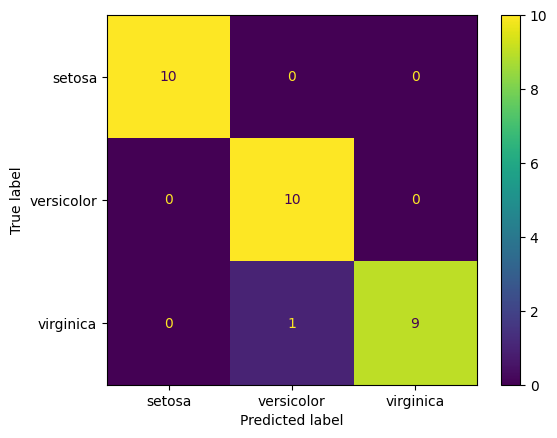

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
# Confusion matrix: performance evaluation tool to evaluate accuracy of a classification model
# model performs quite well, with only one misclassification out of 30 predictions (virginia mislabeled as virginica)

[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



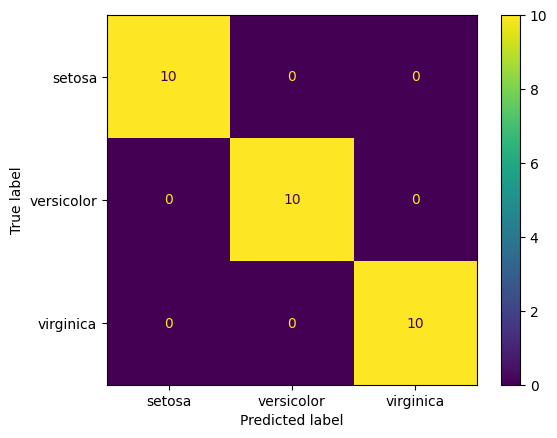

In [23]:
# model의 hyperparameter를 바꿀 수 있음. 굳이 모델을 다시 만들어줄 필요가 없음

standard_knn.set_params(knn__n_neighbors=15)
standard_knn.fit(X_train, y_train)
y_pred = standard_knn.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()

* n_neighbors=15로 바꿨더니 훨씬 더 잘함
* model의 hyperparameter에 따라서 모델의 성능 차이가 큼. 따라서 최적의 hyperparameter를 찾는 것이 중요.
* GridSearch는 model의 hyperparameter가 여러개인 경우 최적의 파라미터 조합을 찾으려고 할 때 사용.

### 3.2. Grid Search

exhaustive search (가능한 모든 조합)를 하다보니 시간이 오래걸리는 단점이 있음. 그래도 n_jobs를 통해서 parallel하게 돌릴 수 있음. -1일 경우 가능한 모든 processor 다 사용

In [24]:
standard_knn = Pipeline([
    ('scaler', StandardScaler()),  # parameter: with_mean (T/F), with_std (T/F)
    ('knn', KNeighborsClassifier(n_neighbors=2)), # parameter: n_neighbors, metric...
], memory='.')

# Set the parameters by cross-validation
tuned_parameters = [
    {
        'scaler__with_mean': [True],
        'knn__n_neighbors': [1, 2, 3, 4, 5],
    },
    {
        'scaler__with_mean': [False, True],
        'knn__n_neighbors': [15, 30],
    }
]

scores = ['precision_macro', 'recall_macro']

for score in scores:
    print('-'*50)
    print('# Tuning hyper-parameters for {}\n'.format(score))

    # tuned_parameter: list 혹은 dictionary. dict내에 있는 hyperparameter 조합들을 실험해줌.
    # cv = 5: cross-validation 사용
    # scoring: estimator 평가를 어떻게 할지 (to find best parameter). score를 직접 계산해주는 callable일 수 있거나, 여기처럼 이미 구현된 특정 scoring method일 수 있음
    clf = GridSearchCV(
        standard_knn, tuned_parameters, scoring=score, cv=5, n_jobs=-1
    )
    clf.fit(X_train, y_train) # CV ->

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()

    print("Grid scores on development set:")
    params = clf.cv_results_['params']
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, params):
        print('{:.3f} (+/-{:.3f}) for {}'.format(mean, 2*std, params))
    print()

    print("Detailed classification report:")
    y_true, y_pred = y_test, clf.predict(X_test)   # Call predict on the estimator with the best found parameters
    print(classification_report(y_true, y_pred, target_names=target_names))
    print()

--------------------------------------------------
# Tuning hyper-parameters for precision_macro

Best parameters set found on development set:
{'knn__n_neighbors': 4, 'scaler__with_mean': True}

Grid scores on development set:
0.939 (+/-0.042) for {'knn__n_neighbors': 1, 'scaler__with_mean': True}
0.934 (+/-0.062) for {'knn__n_neighbors': 2, 'scaler__with_mean': True}
0.938 (+/-0.065) for {'knn__n_neighbors': 3, 'scaler__with_mean': True}
0.951 (+/-0.029) for {'knn__n_neighbors': 4, 'scaler__with_mean': True}
0.948 (+/-0.039) for {'knn__n_neighbors': 5, 'scaler__with_mean': True}
0.942 (+/-0.037) for {'knn__n_neighbors': 15, 'scaler__with_mean': False}
0.942 (+/-0.037) for {'knn__n_neighbors': 15, 'scaler__with_mean': True}
0.899 (+/-0.085) for {'knn__n_neighbors': 30, 'scaler__with_mean': False}
0.899 (+/-0.085) for {'knn__n_neighbors': 30, 'scaler__with_mean': True}

Detailed classification report:
              precision    recall  f1-score   support

      setosa       1.00      1

* GridSearchCV를 Pipeline이랑 적용 안 하고 할 경우:

```
scaler = StandardScaler()
knn = KNeighborsClassifier()

scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
gv_model = GridSearchCV(knn, parameter_set, scoring=score, cv=5, n_jobs=-1)
gv_model.fit(X_train_scaled, y_train)

```


* 근데 사실 위 코드는 틀렸음...
![](https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/featured.png)
* 전처리를 split하기 전의 전체 training에 대해서 하면 안 됨 (미래참조 하는 샘). GridSearchCV의 cv 기능을 사실상 못 씀... 데이터셋을 수동으로 k-fold로 나눠서 각각의 CV 단계에서 training set에 대해 scaling 해주고 gv_model을 fit 해줘야함.
* 이런 복잡하고 귀찮은 코드를 한방에 해결해주는 것이 Pipeline! 그래서 Pipeline의 두번째 장점은 전처리를 포함해서 cross-validation을 해주는 것.

## 4. Application: Face Verification

Finally, we will go through how we can apply K-Fold cross validation on the task of face verification (i.e., determining whether a pair of faces belong to the same identity).

* Face Verification task: 2 얼굴 이미지를 가지고, 그 두 얼굴이 같은 사람인지 아닌지를 판단을 해줌.
* 이미지를 pixel-wise로 비교해서 분류하면 안 됨 (단위 pixel로만 표현할 수 없는 정보들이 있음 - 눈 크기 등등).
* 이미지에서 중요한 정보가 많이 섞여 있는데, 이걸 하나하나 수치화해서 벡터로 모은게 embedding. embedding 사이의 상대거리가 이미지의 상관관계가 유지 될 수 있도록 embedding을 만들어줌. 따라서 embedding의 거리를 재면 해당되는 이미지들의 비슷한 정도를 파악할 수 있음.
* 다양한 방법이 있겠지만, 저희는 두 이미지를 embedding 시켜서 embedding vector 두개에 대한 거리를 재서 거리가 일정 threshold 이상이면 다른 사람, 더 적으면 같은 사람으로 분류. 따라서 parameter는 threshold임.


![](https://arize.com/wp-content/uploads/2022/06/blog-king-queen-embeddings.jpg)



### 4.1. Load Labeled Faces in the Wild (LFW) benchmark dataset [1]

[1] G. Huang et al., "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments," Technical report 2007.

In [26]:
LFW = h5py.File(io.BytesIO(requests.get(f'{BASE_DIR}/Data/LFW.hdf5').content), "r+") #  바이트열류 객체를 기대하고 bytes 객체를 생성함, r+: Read/write, file must exist
faces = LFW["imgs"]
labels = LFW["labels"]
labels = np.asarray(labels)

In [27]:
print(faces.shape)  # 112 * 112 크기의 rgb 이미지 1000개 (1000개의 얼굴)
print(labels.shape) # 옆에 있는 두개의 이미지가 같은 사람에 대한 것인지 아닌지 boolean

(1000, 112, 112, 3)
(500,)


### 4.2. Dataset Exploration

Provided dataset contains 500 pairs of faces, each marked with a label indicating whether the two faces are the same person. Randomly pick an index, and see how the faces in the dataset looks like.

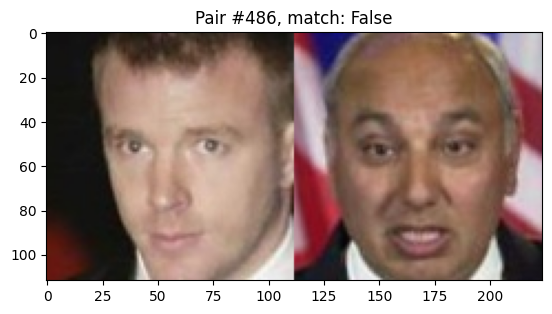

In [29]:
# select random index
idx = np.random.randint(labels.shape[0])
img1 = faces[2*idx]
img2 = faces[2*idx+1]
match = labels[idx]

# plot
plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Pair #%d, match: %r"%(idx, match)
plt.title(title)
plt.show()

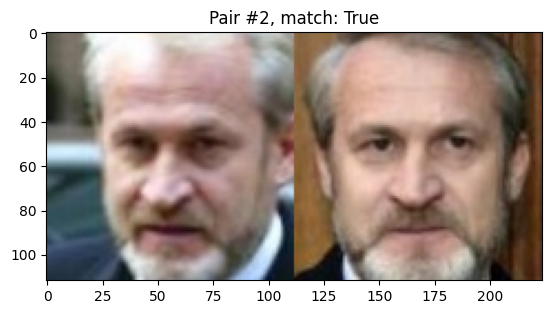

In [30]:
idx = 2    # True
# idx = 423  # False

img1 = faces[2*idx]
img2 = faces[2*idx+1]
match = labels[idx]

# plot
plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Pair #%d, match: %r"%(idx, match)
plt.title(title)
plt.show()

### 4.3. Load Face Features

Load face features extracted by ArcFace [2] recognition network with ResNet50 backbone.

Face feature 크기 512크기의 vector.

[2] J. Deng et al., "ArcFace: Additive Angular Margin Loss for Deep Face Recognition," CVPR 2019.

In [43]:
embeddings = np.load(io.BytesIO(requests.get(f'{BASE_DIR}/Data/embeddings.npy').content))
print(embeddings.shape)

(1000, 512)


### 4.4. Calculate Feature Distances Between the Two Faces

Face verification works by extracting the feature vectors for a pair of input faces, normalizing them, and calculating the L2 distance, and comparing against a threshold. In our case, embeddings are already normalized

Implement the calc_distance() function which calculates the L2 distance between the two feature vectors $x$ and $y$, i.e.,

calc_distance($x$, $y$) = $\sum_{i=1}^n (x_{i}/||x||-y_{i}/||y||)^2$,

where n is the length of the feature vector, and $||x||, ||y||$ is the L2 norm of $x$ and $y$ calculated by

$||x|| = (\sum_{i=1}^n x_{i}^2)^{1/2}.$

You can use np.linalg.norm() to calculate the norm of the feature vector

We must normalize the embeddings so that both are fairly comparable (같은 scale로)

(500,)


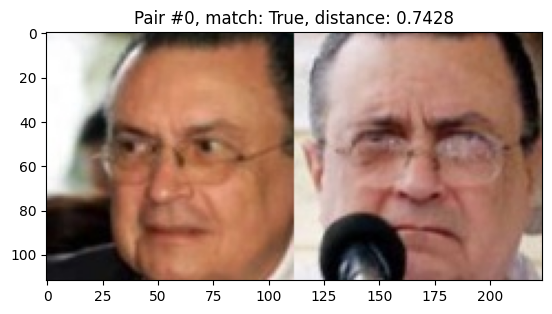

In [45]:
def calc_distance(feature1, feature2):
    # normalize feature 1 and feature 2
    # feature1 /= np.linalg.norm(feature1)  # (500, 512)
    # feature2 /= np.linalg.norm(feature2)

    # calculate the l2 distance
    distance = np.sum(np.square(feature1-feature2), 1)  # 각각의 이미지마다 feature vector의 elements 512개를 합해야함 ==> 1 axis에 대해서 sum => (500, )

    return distance

embeddings1 = embeddings[0::2]  # 0번째 index에서 시작해서 2씩 띄어서 값을 사용 (짝수 얼굴) -- (500, 512)
embeddings2 = embeddings[1::2]  # 홀수 얼굴

# calculate distance
dist = calc_distance(embeddings1, embeddings2)
print(dist.shape)

idx = 0
# idx = 331
# idx = np.random.randint(labels.shape[0])
img1 = faces[2*idx]
img2 = faces[2*idx+1]
match = labels[idx]
distance = dist[idx]

# plot
plt.figure()
plt.imshow(np.concatenate([img1, img2], axis = 1))
title = "Pair #%d, match: %r, distance: %.4f"%(idx, match, distance) # should be 0.7428
plt.title(title)
plt.show()

### 4.5. Plot (Receiver Operating Characteristic) ROC curve

An ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. (임계값의 변화에 따라서 classifier의 성능을 나타내주는 graph)

It is created by plotting the true positive rate ($TPR$) against the false positive rate ($FPR$) at various threshold settings. TPR and FPR are calculated as follows:

$ TPR = TP / (TP + FN), $

$ FPR = FP / (FP + TN) $

where $TP, TN, FP, FN$ are True Positive, True Negative, False Positive, and False Negative, respectively.

![Labels](https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/main/Images/labels.png)

Finally, the accuracy is defined as follows,

$accuracy = (TP+TN)/(TP+TN+FP+FN).$

Try implement calculate_roc($threshold$, $dist$, $label$) function, which calculates the TPR, FPR, and accuracy for the list of feature distance values $dist$ and ground truth labels $label$ and a threshold $threshold$.

[]

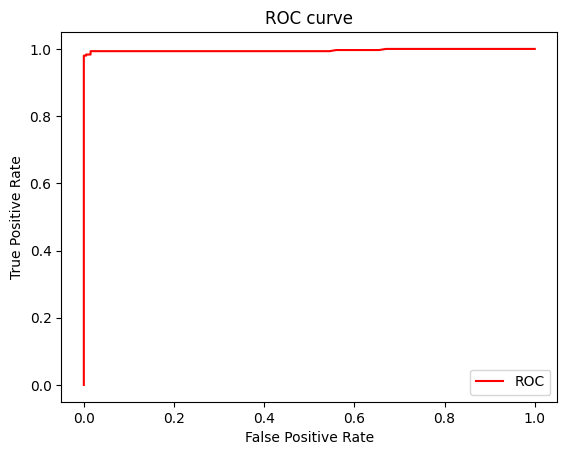

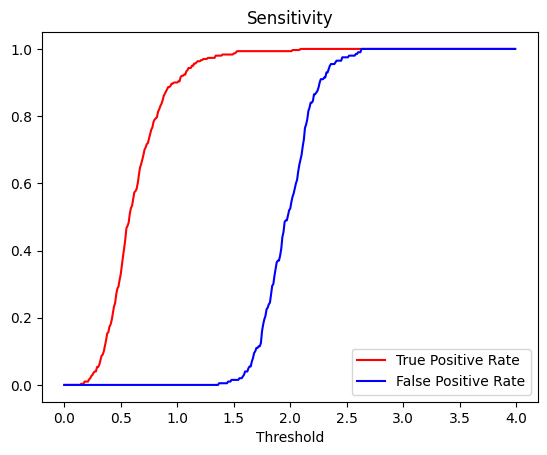

In [50]:
def calculate_roc(threshold, distances, labels):
    # threshold: a threshold value (float). If distance is below the threshold, we determine that the two faces are the same
    # distances: a list of distance values between pairs of two faces
    # labels: a list of labels (boolean) indicating the ground truth of whether the two faces match or not

    # predict the results based on the calculated distance and the given threshold
    predict = np.less(distances, threshold)

    # calculate TP/FP/TN/FN
    tp = np.sum(np.logical_and(predict, labels))
    fp = np.sum(np.logical_and(predict, np.logical_not(labels)))
    tn = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(labels)))
    fn = np.sum(np.logical_and(np.logical_not(predict), labels))

    # calculate TPR, FPR and accuracy
    TPR = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    FPR = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / distances.size
    return TPR, FPR, acc

# for each threshold, calculate metrics necessary to draw the ROC curve
thresholds = np.arange(0, 4, 0.01)    # [0:4( 0.01 간격으로 [0, 0.01, 0.02, ..., 3.98, 3.99]
TPR = np.zeros((len(thresholds)))
FPR = np.zeros((len(thresholds)))
for threshold_idx, threshold in enumerate(thresholds):   # 각각의 threshold에 대해서 tpr, fps를 구하기 (acc는 버리기)
    TPR[threshold_idx], FPR[threshold_idx], _ = calculate_roc(threshold, dist, labels)

# plot ROC curve
fig = plt.figure()
plt.plot(FPR, TPR, color = 'r', label = 'ROC')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
_title = "ROC curve"
plt.title(_title)
plt.legend()
plt.plot()

# plot sensitivity curve
fig = plt.figure()
plt.plot(thresholds, TPR, color = 'r', label = 'True Positive Rate')
plt.plot(thresholds, FPR, color = 'b', label = 'False Positive Rate')
plt.xlabel("Threshold")
_title = "Sensitivity"
plt.title(_title)
plt.legend()
plt.plot()

### 4.6. Calculate accuracy

Finally, let's find the best distance threshold for the LFW dataset by performing a K-Fold cross validation.

In [48]:
folds = 10

n_pairs = min(len(labels), embeddings1.shape[0])
thresholds = np.arange(0, 4, 0.01)     # [0:4( 0.01 간격으로: [0, 0.01, 0.02, ..., 3.98, 3.99]
n_thresholds = len(thresholds)
k_fold = KFold(n_splits=folds, shuffle=True)

accuracy = np.zeros((folds))
indices = np.arange(n_pairs) # [0, 1, 2, ..., 498, 499]

for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
    # Find the best threshold for the fold
    acc_train = np.zeros((n_thresholds))
    for threshold_idx, threshold in enumerate(thresholds):
        _, _, acc_train[threshold_idx] = calculate_roc(threshold, dist[train_set], labels[train_set])

    best_threshold_index = np.argmax(acc_train)

    _, _, accuracy[fold_idx] = calculate_roc(thresholds[best_threshold_index],
                                                  dist[test_set], labels[test_set])
    print('best threshold for fold %d: %.2f (fold accuracy %.4f, test fold accuracy %.4f)'
          %(fold_idx, thresholds[best_threshold_index], acc_train[best_threshold_index], accuracy[fold_idx]))

acc, std = np.mean(accuracy), np.std(accuracy)
print('Fold accuracy: %.4f+-%.4f' % (acc, std))

best threshold for fold 0: 1.53 (fold accuracy 0.9889, test fold accuracy 1.0000)
best threshold for fold 1: 1.53 (fold accuracy 0.9956, test fold accuracy 0.9400)
best threshold for fold 2: 1.53 (fold accuracy 0.9889, test fold accuracy 1.0000)
best threshold for fold 3: 1.34 (fold accuracy 0.9889, test fold accuracy 0.9800)
best threshold for fold 4: 1.53 (fold accuracy 0.9911, test fold accuracy 0.9800)
best threshold for fold 5: 1.53 (fold accuracy 0.9889, test fold accuracy 1.0000)
best threshold for fold 6: 1.34 (fold accuracy 0.9911, test fold accuracy 0.9600)
best threshold for fold 7: 1.53 (fold accuracy 0.9889, test fold accuracy 1.0000)
best threshold for fold 8: 1.53 (fold accuracy 0.9911, test fold accuracy 0.9800)
best threshold for fold 9: 1.53 (fold accuracy 0.9889, test fold accuracy 1.0000)
Fold accuracy: 0.9840+-0.0196
